In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
it = 10
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/elmo/{0}'.format(it))

# ELMO для последовательностей товаров

###Собираем эмбеддинги продуктов

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
products = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/products.csv')

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/2")

In [ ]:
tensor_list = tf.convert_to_tensor(["hello adf fff"])

In [ ]:
tensor_list

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'hello adf fff'], dtype=object)>

In [ ]:
np.mean(elmo.signatures["default"](tensor_list)['elmo'][0], axis=0)

array([ 0.02389512, -0.58518916,  0.09305262, ..., -0.42391977,
        0.07482383,  0.0079967 ], dtype=float32)

In [ ]:
tensor_list = tf.convert_to_tensor([products.loc[1, 'product_name']])

In [ ]:
tensor_list

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'All-Seasons Salt'], dtype=object)>

In [ ]:
np.mean(elmo.signatures["default"](tensor_list)['elmo'][0], axis=0)

array([-0.42232463,  0.18180431,  0.07759979, ...,  0.21379648,
       -0.40003544, -0.19305152], dtype=float32)

In [ ]:
elmo = hub.load("https://tfhub.dev/google/elmo/2")

elmo_embeddings = {}

for ind in tqdm(products.index, position=0):
  tensor_list = tf.convert_to_tensor([products.loc[ind, 'product_name']])
  elmo_embeddings[products.loc[ind, 'product_id']] = np.mean(elmo.signatures["default"](tensor_list)['elmo'][0], axis=0)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/elmo/elmo_embeddings.pkl', 'wb') as f:
  pkl.dump(elmo_embeddings, f)

100%|██████████| 49688/49688 [1:36:29<00:00,  8.58it/s]


###Считываем данные и подготавливаем выборку

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/elmo/elmo_embeddings.pkl', 'rb') as f:
  elmo_embeddings = pkl.load(f)

###Понижаем размерность векторов ELMO

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
elmo_matrix = np.zeros((len(id_to_token), 1024))
for i_d, token in id_to_token.items():
  elmo_matrix[i_d, :] = elmo_embeddings[token]

In [ ]:
pca = PCA(n_components=13, random_state=432)

elmo_matrix_red = pca.fit_transform(elmo_matrix)

In [ ]:
elmo_to_df = np.zeros((elmo_matrix_red.shape[0], elmo_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  elmo_to_df[i_d, 0] = token
  elmo_to_df[i_d, 1:] = elmo_matrix_red[i_d, :]

In [ ]:
elmo_df = pd.DataFrame(elmo_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(elmo_df, how='inner', on='product_id')
new_data_val = data_val.merge(elmo_df, how='inner', on='product_id')
new_data_test = data_test.merge(elmo_df, how='inner', on='product_id')

prods_df = train_positive.merge(elmo_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Обучаем и проверяем качество на валидации

100%|██████████| 6605/6605 [05:14<00:00, 21.02it/s]




{1: 0.4867524602573808, 2: 0.44231642694928086, 3: 0.40693918748422564, 4: 0.37779460005046683, 5: 0.35540625788542485, 6: 0.3370943729497829, 7: 0.3216425146894613, 8: 0.308307108611802, 9: 0.29734319238673196, 10: 0.2874491727046514}
{1: 0.08774678589445764, 2: 0.14781502363885995, 3: 0.19614654230535486, 4: 0.2344830347543294, 5: 0.26869635196330094, 6: 0.29944883154511237, 7: 0.32675915283358836, 8: 0.3519387152787104, 9: 0.375926487255584, 10: 0.39739987471766963}


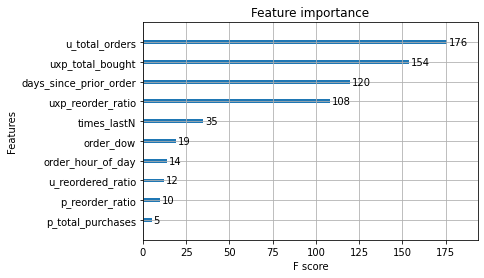

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

100%|██████████| 6605/6605 [04:33<00:00, 24.13it/s]




{1: 0.4544605324614666, 2: 0.41606725829051844, 3: 0.3835590845399413, 4: 0.35862525299704195, 5: 0.3384757901292162, 6: 0.32191966370854314, 7: 0.309764684949186, 8: 0.29963090233758133, 9: 0.2890867640844327, 10: 0.2802155201174271}
{1: 0.07915782004545505, 2: 0.13520146887131887, 3: 0.1804229303753051, 4: 0.21932269068602686, 5: 0.25254073032951346, 6: 0.28222238140727546, 7: 0.3104240274367403, 8: 0.338238936818605, 9: 0.36107282738309104, 10: 0.3825879217938798}


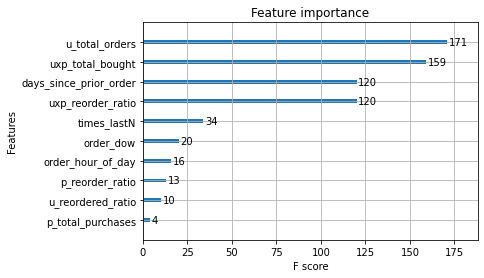

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_elmo_feats = {}

metric_with_elmo_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/elmo/{0}/metric_with_elmo_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_with_elmo_feats, f)